## Фреймворк PyTorch для разработки искусственных нейронных сетей

### Домашнее задание №5

**Урок 5. Сегментация изображений**

Необходимо подготовить датасет https://www.kaggle.com/olekslu/makeup-lips-segmentation-28k-samples для обучения модели на сегментацию губ

Обучить модель на выбор из segmentation_models_pytorch

У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/nWMoBVgvWYcI7g

**Установка моделей сегментации**

In [1]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-4kc0ud5n
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-4kc0ud5n
  Resolved https://github.com/qubvel/segmentation_models.pytorch to commit 8523324c116dcf7be6bddb73bf4eb1779ef6e611
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


**Библиотеки**

In [2]:
import os
import time

from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import cv2

import torch
from torch import nn, optim

import segmentation_models_pytorch as smp

In [3]:
from google.colab import files

In [4]:
uploaded = files.upload()

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


**Загрузка датасета**

In [5]:
!kaggle datasets download -d olekslu/makeup-lips-segmentation-28k-samples

makeup-lips-segmentation-28k-samples.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip makeup-lips-segmentation-28k-samples.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: set-lipstick-original/mask/mask00023595.png  
  inflating: set-lipstick-original/mask/mask00023596.png  
  inflating: set-lipstick-original/mask/mask00023597.png  
  inflating: set-lipstick-original/mask/mask00023598.png  
  inflating: set-lipstick-original/mask/mask00023599.png  
  inflating: set-lipstick-original/mask/mask00023600.png  
  inflating: set-lipstick-original/mask/mask00023601.png  
  inflating: set-lipstick-original/mask/mask00023602.png  
  inflating: set-lipstick-original/mask/mask00023603.png  
  inflating: set-lipstick-original/mask/mask00023604.png  
  inflating: set-lipstick-original/mask/mask00023605.png  
  inflating: set-lipstick-original/mask/mask00023606.png  
  inflating: set-lipstick-original/mask/mask00023607.png  
  inflating: set-lipstick-original/mask/mask00023608.png  
  inflating: set-lipstick-original/mask/mask00023609.png  
  inflating: set-lipstick-original/mask/mask000

In [7]:
DATASET_FILEPATH = Path('set-lipstick-original')
IMAGES = '720p'
MASKS = 'mask'
LIST_CSV = 'list.csv'

In [8]:
IMAGES_FILEPATH = DATASET_FILEPATH.joinpath(IMAGES)
MASKS_FILEPATH = DATASET_FILEPATH.joinpath(MASKS)
LIST_CSV_FILEPATH = DATASET_FILEPATH.joinpath(LIST_CSV)

Смотрим описание датасета

In [9]:
df_lips_images = pd.read_csv(LIST_CSV_FILEPATH)
df_lips_images.head()

,filename,width,height,class,xmin,ymin,xmax,ymax,mask
0,image00000001.jpg,1280,720,Lips,661,394,776,444,mask00000001.png
1,image00000002.jpg,1280,720,Lips,557,336,682,392,mask00000002.png
2,image00000003.jpg,1280,720,Lips,553,369,684,427,mask00000003.png
3,image00000004.jpg,1280,720,Lips,555,351,681,408,mask00000004.png
4,image00000005.jpg,1280,720,Lips,555,351,680,407,mask00000005.png


In [10]:
features = ['filename', 'mask']

df_lips_images = df_lips_images[features]
df_lips_images.head()

,filename,mask
0,image00000001.jpg,mask00000001.png
1,image00000002.jpg,mask00000002.png
2,image00000003.jpg,mask00000003.png
3,image00000004.jpg,mask00000004.png
4,image00000005.jpg,mask00000005.png


In [11]:
list_of_an_images = sorted([i for i in Path(IMAGES_FILEPATH).iterdir()])
list_of_a_masks = sorted([i for i in Path(MASKS_FILEPATH).iterdir()])

Проверяем соответствие количества картинок и масок

In [12]:
len(list_of_an_images), len(list_of_a_masks)

(28594, 28540)

Т.к. количество не совпадает, убираем лишнее

In [13]:
df_lips_images = df_lips_images.loc[df_lips_images['mask'].isin([i.name for i in list_of_a_masks])]
df_lips_images.reset_index(drop=True, inplace=True)
df_lips_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28540 entries, 0 to 28539
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  28540 non-null  object
 1   mask      28540 non-null  object
dtypes: object(2)
memory usage: 446.1+ KB


Задаем размер изображения

In [14]:
IMG_SIZE = 256

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Загружаем одну из предобученных моделей из выбранного набора

In [16]:
model = smp.FPN(encoder_name='resnet50',
                encoder_weights='imagenet',
                classes=1,
                activation='sigmoid'
               ).to(device=device)

preprocess_input = smp.encoders.get_preprocessing_fn('resnet50', pretrained='imagenet')

**Необхожимые функции и классы**

In [17]:
def resize_an_image_and_mask(image_filename, mask_filename, new_size):
    
    image = cv2.imread(str(IMAGES_FILEPATH.joinpath(image_filename)))
    mask = cv2.imread(str(MASKS_FILEPATH.joinpath(mask_filename)))
    
    resized_image = cv2.cvtColor(cv2.resize(image, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    resized_mask = cv2.cvtColor(cv2.resize(mask, (new_size, new_size)), cv2.COLOR_BGR2RGB)
    
    return resized_image, resized_mask


class LipsDataset(torch.utils.data.Dataset):
    
    def __init__(self, data, preprocessing=None):
        
        self.data = data
        self.preprocessing = preprocessing
        
        self.images_paths = self.data.iloc[:, 0]
        self.masks_paths = self.data.iloc[:, 1]
        
        self.data_len = len(self.data.index)
        
    def __len__(self):
        return self.data_len
    
    def __getitem__(self, idx):
        
        img_path = self.images_paths[idx]
        mask_path = self.masks_paths[idx]
        
        img, mask = resize_an_image_and_mask(img_path, mask_path, IMG_SIZE)
        
        img = img.astype(float)
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            img = torch.as_tensor(img)
            img /= 255.0
        
        img = img.permute(2, 0, 1)
      
        cls_mask_1 = mask[..., 1]

        cls_mask_1 = np.where(mask > 50, 1, 0)[:,:,1]
        
        cls_mask_1 = cls_mask_1.astype('float')

        masks = [cls_mask_1]
        
        masks = torch.as_tensor(masks, dtype=torch.float)
        
        
        return img.float(), masks

Разбиваем датасет на тренировочную и валидационную части

In [18]:
X_train, X_valid = train_test_split(df_lips_images, test_size=0.3,random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_valid.reset_index(drop=True, inplace=True)

train_data = LipsDataset(X_train, preprocessing=preprocess_input)
valid_data = LipsDataset(X_valid, preprocessing=preprocess_input)

Загружаем даталоадеры

In [19]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=4, shuffle=False)

Проверяем одну из картинок

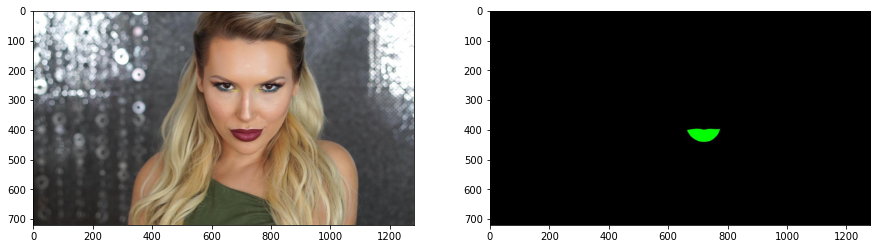

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
img_pic = plt.imread(list_of_an_images[0])
img_mask = plt.imread(list_of_a_masks[0])
ax[0].imshow(img_pic)
ax[1].imshow(img_mask)
plt.show()

<ipython-input-17-5428ebffde26>:53: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  masks = torch.as_tensor(masks, dtype=torch.float)


torch.Size([8, 3, 256, 256]) torch.Size([8, 1, 256, 256])
tensor(-1.9467) tensor(2.6226)
tensor(0.) tensor(1.)


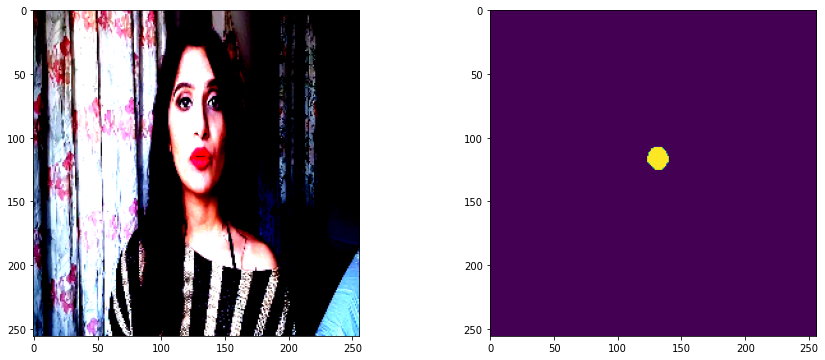

In [21]:
for img, target in train_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[...,0])
    break

Задаем параметры сети

In [23]:
from segmentation_models_pytorch import utils as smp_utils

In [24]:
criterion = smp_utils.losses.BCELoss()
metrics = [smp_utils.metrics.IoU(), ]
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [25]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

**Тренируем модель**

In [26]:
max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')

Epoch: 1
valid: 100%|██████████| 2141/2141 [05:19<00:00,  6.71it/s, bce_loss - 0.001675, iou_score - 0.8503]
Model saved!


In [27]:
net = torch.load('./best_model.pth')

In [28]:
data_iter = iter(train_loader)

In [39]:
images, labels = next(data_iter)
images, labels = images.to(device), labels.to(device)

outputs = model(images)

Сравниваем размеченные и полученные в результате обучения резульаты сегментации

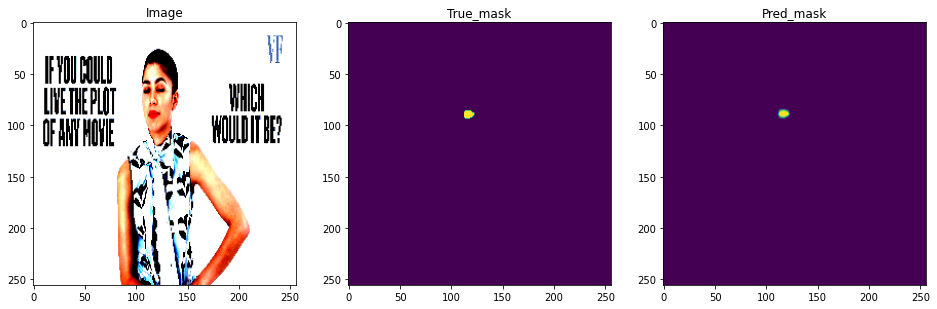

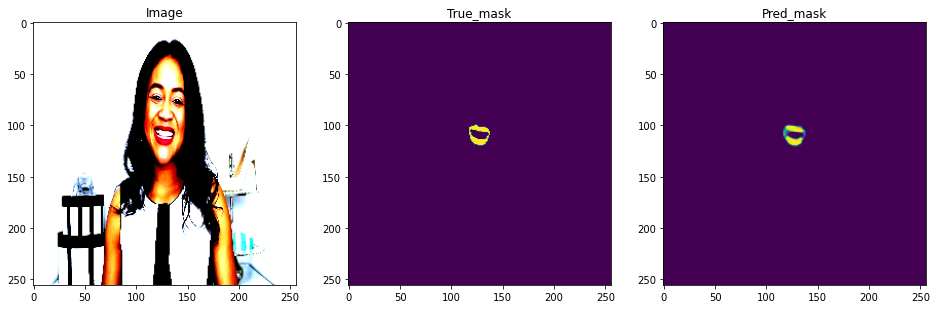

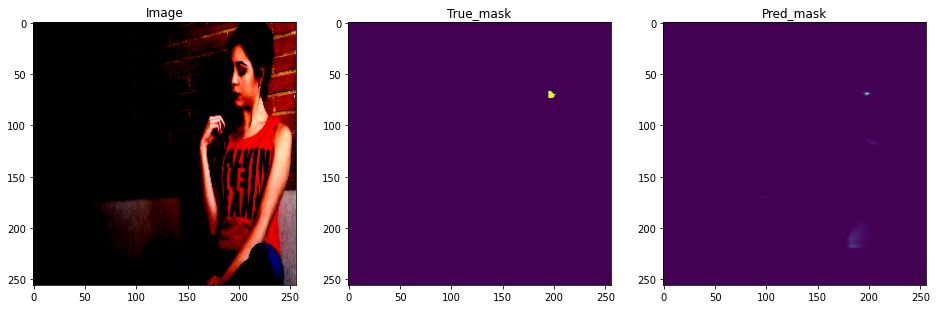

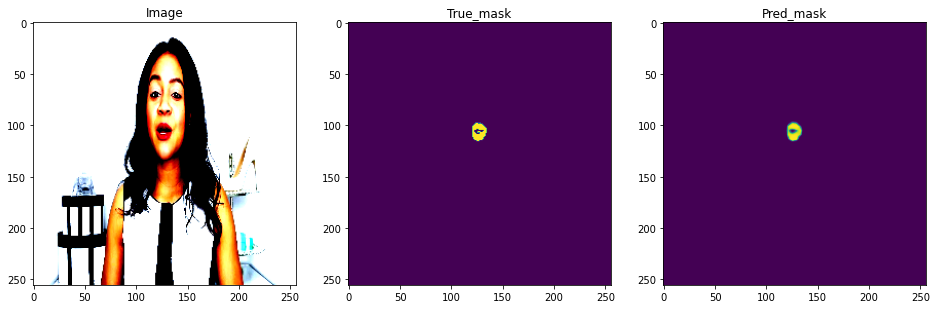

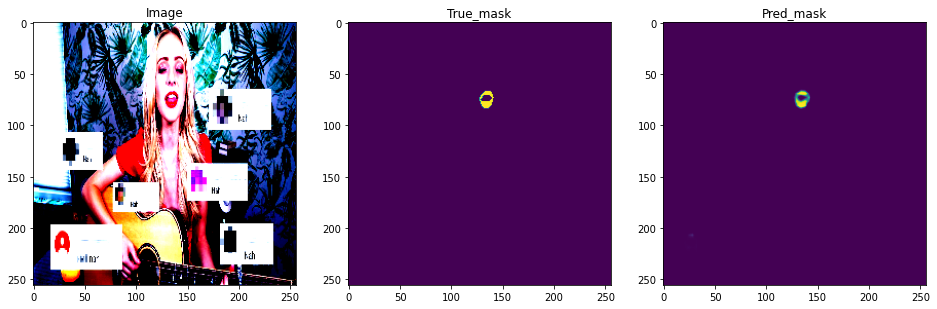

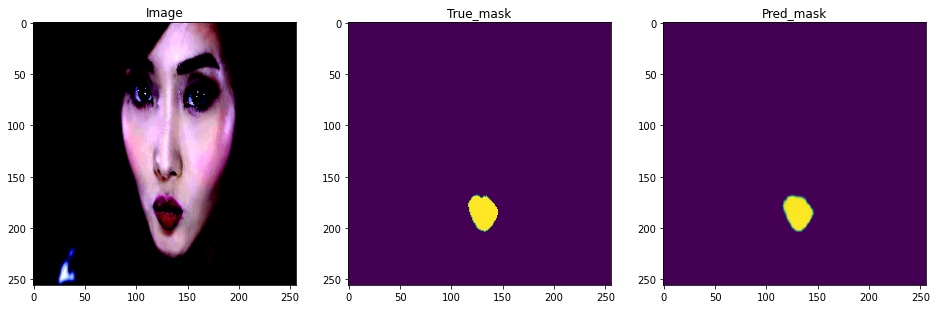

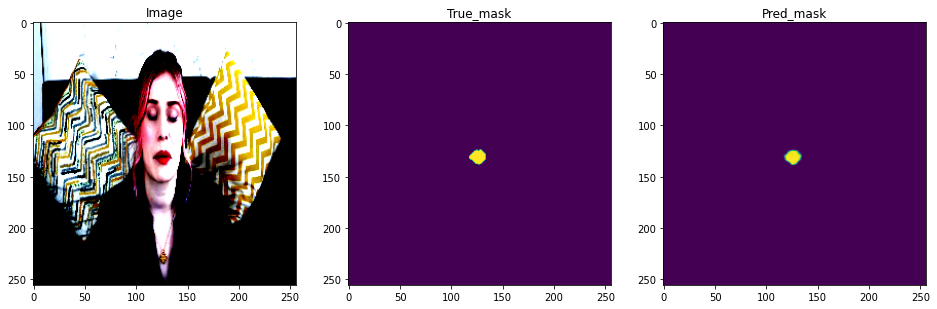

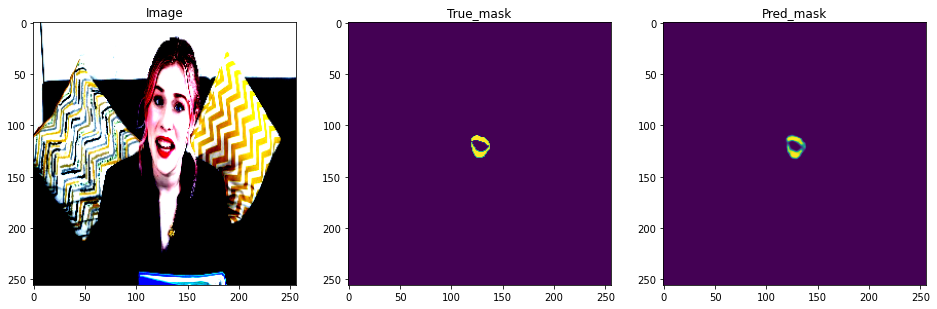

In [41]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0)[...,0])
    ax_2.set_title('True_mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0)[...,0])
    ax_3.set_title('Pred_mask')